In [1]:
from sklearn.preprocessing import StandardScaler
import tsdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Times New Roman'
# 高清显示 retina
# %config InlineBackend.figure_format = 'retina'

In [2]:
start_day = 0  # start day 0
use_days = 30  # use 30 days

data = tsdb.load("beijing_multisite_air_quality", use_cache=True)['X']
datas = data.loc[:, ['No', 'PM2.5','station']].copy()
datas = datas[(start_day*24<datas.No) & (datas.No<=start_day*24+use_days*24)] # load data from start_day to start_day+use_days, each day has 24 hours
datas['station'] = datas['station'].astype('category').cat.codes
Y = datas.pivot(index='No', columns='station', values='PM2.5').reset_index(drop=True).to_numpy() # target data
Y_raw = Y.copy() # raw data
Y = StandardScaler().fit_transform(Y) # standardize
# Y = pd.DataFrame(Y)
# 时间从2013-03-01 00:00:00开始，2023-03-30 23:00:00结束，间隔1h
X = pd.date_range(start='2013-03-01 00:00:00', periods=use_days*24, freq='h')

# 统计Y的总体缺失率
missing_rate = np.sum(np.isnan(Y)) / Y.size
print(f"Missing rate: {missing_rate:.2%}")

Missing rate: 0.54%


In [12]:
pd.DataFrame(Y_raw).describe().T.iloc[:,[4,6]].mean()

25%     25.958333
75%    152.000000
dtype: float64

In [8]:
pd.DataFrame(Y_raw).describe().T.mean(axis=1)

0     208.343635
1     199.516218
2     193.153902
3     214.097720
4     200.169430
5     206.034584
6     207.421141
7     212.519443
8     214.818807
9     209.555950
10    210.210830
11    201.750801
dtype: float64

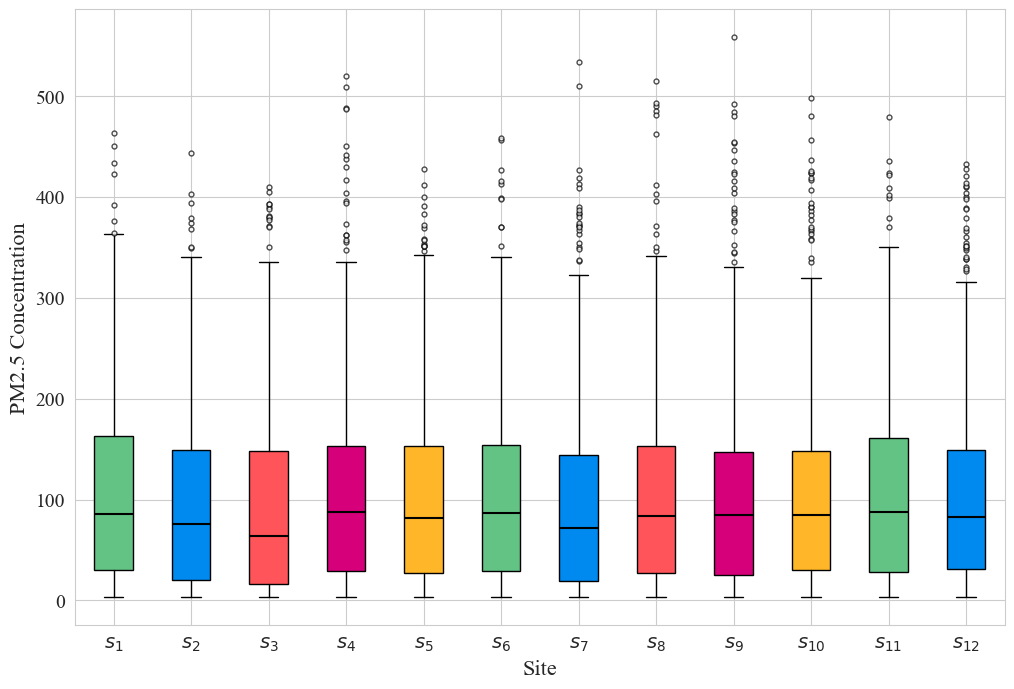

In [5]:
data = []
for i in Y_raw.T:
    data.append([float(j) for j in i if ~np.isnan(j)])

# 自定义颜色列表
colors = ['#63C384', '#008AEF', '#FF555A', '#D6007B', '#FFB628', 
          '#63C384', '#008AEF', '#FF555A', '#D6007B', '#FFB628', 
          '#63C384', '#008AEF']

plt.figure(figsize=(12, 8))
bplot = plt.boxplot(data, patch_artist=True, showfliers=True, tick_labels=[f'$s_{{{j + 1}}}$' for j in range(12)])

# 为每个 box 上色
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# 修改离群点（fliers）的样式
for flier in bplot['fliers']:
    flier.set(marker='o', markersize=3.5, markerfacecolor='white', markeredgecolor='black', alpha=0.7)
# 修改中位数线颜色为黑色
for median in bplot['medians']:
    median.set(color='black', linewidth=1.5)
plt.xlabel('Site', fontsize=16)
plt.ylabel('PM2.5 Concentration', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./res/figs/over_boxs.png', dpi=300, bbox_inches='tight')
plt.show()

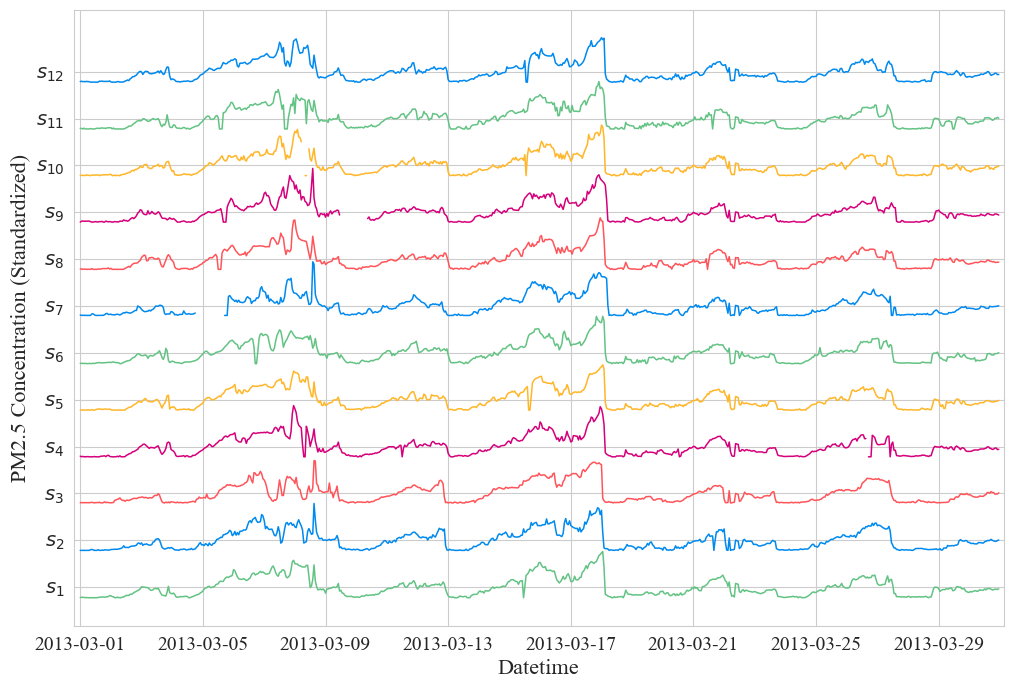

In [6]:
# 定义颜色列表
colors = ['#63C384', '#008AEF', '#FF555A', '#D6007B', '#FFB628', 
          '#63C384', '#008AEF', '#FF555A', '#D6007B', '#FFB628', 
          '#63C384', '#008AEF']

# 创建图形
plt.figure(figsize=(12, 8))

# 定义偏移量
offset = 5  # 每条曲线的偏移量

# 绘制曲线
for i in range(12):
    plt.plot(X, Y[:, i] + i * offset, label=f'Station {i+1}', color=colors[i], linewidth=1.1)

plt.xticks(fontsize=14)  # 设置 x 轴刻度
plt.yticks(np.arange(0, 12 * offset, offset), 
               labels=[f'$s_{{{j + 1}}}$' for j in range(12)], fontsize=14)  # 设置 y 轴刻度
# x轴范围在原有时间最大最小的基础上增加或减少3个小时时长
plt.xlim(X[0] - pd.Timedelta(hours=5), X[-1] + pd.Timedelta(hours=4))
plt.xlabel('Datetime', fontsize=16)
plt.ylabel('PM2.5 Concentration (Standardized)', fontsize=16)
plt.savefig('./res/figs/over_lines.png', dpi=300, bbox_inches='tight')
plt.show()